In [15]:
!pip install lightgbm

     |████████████████████████████████| 1.7 MB 2.8 MB/s eta 0:00:01


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import log_loss
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
import tqdm
from tqdm import tqdm
import warnings
warnings. filterwarnings("ignore") 
from scipy import signal
from biosppy.signals import ecg 
from biosppy.signals import eeg
from biosppy.signals import resp
from scipy.interpolate import interp1d 
import phik
import dask.array as ar
import pickle
import joblib

In [2]:
train_data=dd.read_csv("pilot_train_eda_fe")
train_data=train_data.compute()

In [ ]:
test_data=dd.read_csv("test.csv")

In [3]:
test_data=test_data.drop(['id','experiment','seat'],axis=1)

In [4]:
test_data=test_data.fillna(0).compute()

In [3]:
eeg_features=['eeg_fp1', 'eeg_f7', 'eeg_f8','eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3','eeg_pz', 'eeg_f3',
              'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz','eeg_c3', 'eeg_cz', 'eeg_o2']

In [7]:
#https://stackoverflow.com/questions/35588782/how-to-average-a-signal-to-remove-noise-with-python

def remove_noise(data,w):
    n=5 #oder of the filter
    
    b, a = signal.butter(n,w,fs=256) #design a butterworth filter with order N and critical frequnecy w. This will return the filter coefficents
    return signal.filtfilt(b, a, data) 


In [8]:
#filtered ecg for test data

w=100 
test_data["filtered_ecg"]=dd.from_array(remove_noise(test_data["ecg"],w))
print("Added filtered ecg data")
test_data=test_data.drop("ecg",axis=1)
print("Dropped noisy ecg data")


Added filtered ecg data
Dropped noisy ecg data


In [9]:
#filtered r for test data
w=0.7 

test_data["filtered_r"]=dd.from_array(remove_noise(test_data["r"],w))
print("Added filtered r data")
test_data=test_data.drop("r",axis=1)
print("Dropped noisy r data")

Added filtered r data
Dropped noisy r data


In [10]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
def interpolation_fn(timestamps,biosppy_ts, biosppy_values):

    interpolation = interp1d(biosppy_ts,biosppy_values, kind="linear", fill_value="extrapolate") #Kind can be linear, quadratic or cubic. fill value is NAN if not given
    return interpolation(timestamps) #this is the time stamps where we need to get the interpolated values That is the time stamps in the dataframe



In [11]:
#extracting ecg information for test data
bio=ecg.ecg(test_data["filtered_ecg"],sampling_rate=256,show=False) 


In [12]:
#interpolate test heart rate data
test_data["heart_rate"]=dd.from_array(interpolation_fn(test_data["time"],bio["heart_rate_ts"],bio["heart_rate"]))



In [13]:
#extracting resppiration rate information for test data

bio=resp.resp(test_data["filtered_r"],sampling_rate=256,show=False) 

#we need to interpolate respiration rate also
test_data["resp_rate"]=dd.from_array(interpolation_fn(test_data["time"],bio["resp_rate_ts"],bio["resp_rate"]))


In [14]:
#deriving potential difference for test data
test_data["fp1_f7"]=test_data["eeg_fp1"]-test_data["eeg_f7"]
test_data["f7_t3"]=test_data["eeg_f7"]-test_data["eeg_t3"]
test_data["t3_t5"]=test_data["eeg_t3"]-test_data["eeg_t5"]
test_data["t5_o1"]=test_data["eeg_t5"]-test_data["eeg_o1"]
test_data["p3_o1"]=test_data["eeg_p3"]-test_data["eeg_o1"]
test_data["c3_p3"]=test_data["eeg_c3"]-test_data["eeg_p3"]
test_data["f3_c3"]=test_data["eeg_f3"]-test_data["eeg_c3"]
test_data["fp1_f3"]=test_data["eeg_fp1"]-test_data["eeg_f3"]

test_data["fzcz"]=test_data["eeg_fz"]-test_data["eeg_cz"]
test_data["czpz"]=test_data["eeg_cz"]-test_data["eeg_pz"]

test_data["fp2_f4"]=test_data["eeg_fp2"]-test_data["eeg_f4"]
test_data["f4_c4"]=test_data["eeg_f4"]-test_data["eeg_c4"]
test_data["c4_p4"]=test_data["eeg_c4"]-test_data["eeg_p4"]
test_data["p4_o2"]=test_data["eeg_p4"]-test_data["eeg_o2"]
test_data["t6_o2"]=test_data["eeg_t6"]-test_data["eeg_o2"]
test_data["t4_t6"]=test_data["eeg_t4"]-test_data["eeg_t6"]
test_data["f8_t4"]=test_data["eeg_f8"]-test_data["eeg_t4"]
test_data["fp2_f8"]=test_data["eeg_fp2"]-test_data["eeg_f8"]

In [15]:
#get power features for eeg test data
bio=eeg.get_power_features(test_data[eeg_features],sampling_rate=256) 

In [16]:
theta_feature=[i+"_theta" for i in eeg_features]
import tqdm 
from tqdm import tqdm
for i in tqdm(range(20)):
    test_data[theta_feature[i]]=interpolation_fn(test_data["time"],bio["ts"],bio["theta"][:,i])
   

100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


In [17]:
alpha_low_feature=[i+"_alpha_low" for i in eeg_features]
# alpha_low for test data
for i in tqdm(range(20)):
    test_data[alpha_low_feature[i]]=interpolation_fn(test_data["time"],bio["ts"],bio["alpha_low"][:,i])
    
    

100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


In [18]:
alpha_high_feature=[i+"_alpha_high" for i in eeg_features]
#alpha_high feature for test data
for i in tqdm(range(20)):
    test_data[alpha_high_feature[i]]=interpolation_fn(test_data["time"],bio["ts"],bio["alpha_high"][:,i])

100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


In [22]:
test_data.columns

Index(['crew', 'time', 'eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6',
       'eeg_t5', 'eeg_t3', 'eeg_fp2',
       ...
       'eeg_pz_alpha_high', 'eeg_f3_alpha_high', 'eeg_fz_alpha_high',
       'eeg_f4_alpha_high', 'eeg_c4_alpha_high', 'eeg_p4_alpha_high',
       'eeg_poz_alpha_high', 'eeg_c3_alpha_high', 'eeg_cz_alpha_high',
       'eeg_o2_alpha_high'],
      dtype='object', length=105)

In [21]:
train_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'crew', 'time',
       'eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6',
       ...
       'eeg_pz_theta', 'eeg_f3_theta', 'eeg_fz_theta', 'eeg_f4_theta',
       'eeg_c4_theta', 'eeg_p4_theta', 'eeg_poz_theta', 'eeg_c3_theta',
       'eeg_cz_theta', 'eeg_o2_theta'],
      dtype='object', length=109)

In [19]:
y=train_data["e"]
train_data=train_data.drop(["e","Unnamed: 0.1","Unnamed: 0","Unnamed: 0.1.1"],axis=1)


In [4]:
train_data,cv_data,y_train,y_cv=train_test_split(train_data,y,stratify=y,test_size=0.25,random_state=1)
print(train_data.shape)
print(y_train.shape)
print(cv_data.shape)

NameError: name 'y' is not defined

**Use RandomForestClassifier to check the important features**

In [8]:
clf=RandomForestClassifier(verbose=1,n_jobs=-1)
clf.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 44.5min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

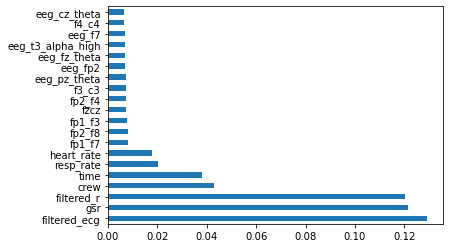

In [13]:
#https://stackoverflow.com/questions/44511636/matplotlib-plot-feature-importance-with-feature-names
pd.Series(data=clf.feature_importances_, index=x.columns).nlargest(20).plot(kind='barh')

We can see that the most important features are the engineered or derived features

# Preprocessing of data

### Preprocessing using Standardization

In [5]:
std=StandardScaler()
stds=[]

In [6]:
#preprocessing filtered ecg,r and gsr signal
features=["filtered_ecg","filtered_r","gsr"]
for each in tqdm(features):
    std.fit(train_data[each].values.reshape(-1,1))
    train_data[each]=std.transform(train_data[each].values.reshape(-1,1))
    stds.append(std)
    cv_data[each]=std.transform(cv_data[each].values.reshape(-1,1))
    test_data[each]=std.transform(test_data[each].values.reshape(-1,1))

100%|██████████| 3/3 [00:00<00:00,  9.45it/s]


In [7]:
#preprocessing respiration rate and heart rate
features=["resp_rate","heart_rate"]
for each in tqdm(features):
    std.fit(train_data[each].values.reshape(-1,1))
    train_data[each]=std.transform(train_data[each].values.reshape(-1,1))
    stds.append(std)
    cv_data[each]=std.transform(cv_data[each].values.reshape(-1,1))
    test_data[each]=std.transform(test_data[each].values.reshape(-1,1))
   

100%|██████████| 2/2 [00:00<00:00,  9.39it/s]


In [8]:
#preprocessing eeg features
eeg_features=['eeg_fp1', 'eeg_f7', 'eeg_f8','eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3','eeg_pz', 'eeg_f3',
              'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz','eeg_c3', 'eeg_cz', 'eeg_o2']
for each in tqdm(eeg_features):
    std.fit(train_data[each].values.reshape(-1,1))
    train_data[each]=std.transform(train_data[each].values.reshape(-1,1))
    stds.append(std)
    cv_data[each]=std.transform(cv_data[each].values.reshape(-1,1))
    test_data[each]=std.transform(test_data[each].values.reshape(-1,1))

100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


In [9]:
pd=["fp1_f7","f7_t3","t3_t5","t5_o1","p3_o1","c3_p3","f3_c3","fp1_f3","fzcz",
"czpz","fp2_f4","f4_c4","c4_p4","p4_o2","t6_o2","t4_t6","f8_t4","fp2_f8"]
for each in tqdm(pd):
    std.fit(train_data[each].values.reshape(-1,1))
    train_data[each]=std.transform(train_data[each].values.reshape(-1,1))
    stds.append(std)
    cv_data[each]=std.transform(cv_data[each].values.reshape(-1,1))
    test_data[each]=std.transform(test_data[each].values.reshape(-1,1))

100%|██████████| 18/18 [00:01<00:00,  9.40it/s]


In [10]:
#preprocessing theta eeg features
features=[i+"_theta" for i in eeg_features]
for each in tqdm(features):
    std.fit(train_data[each].values.reshape(-1,1))
    train_data[each]=std.transform(train_data[each].values.reshape(-1,1))
    stds.append(std)
    cv_data[each]=std.transform(cv_data[each].values.reshape(-1,1))
    test_data[each]=std.transform(test_data[each].values.reshape(-1,1))

100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


In [11]:
#preprocessing alpha_low eeg features
features=[i+"_alpha_low" for i in eeg_features]
for each in tqdm(features):
    std.fit(train_data[each].values.reshape(-1,1))
    train_data[each]=std.transform(train_data[each].values.reshape(-1,1))
    stds.append(std)
    cv_data[each]=std.transform(cv_data[each].values.reshape(-1,1))
    test_data[each]=std.transform(test_data[each].values.reshape(-1,1))

100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


In [12]:
#preprocessing alpha_high eeg features
features=[i+"_alpha_high" for i in eeg_features]
for each in tqdm(features):
    std.fit(train_data[each].values.reshape(-1,1))
    train_data[each]=std.transform(train_data[each].values.reshape(-1,1))
    stds.append(std)
    cv_data[each]=std.transform(cv_data[each].values.reshape(-1,1))
    test_data[each]=std.transform(test_data[each].values.reshape(-1,1))

100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


In [14]:
print(len(stds))
np.save("std",stds)

103


All the numerical features are standardized

In [29]:
test_data.to_csv("test_eda")

**Modeling using standardized features**

In [37]:
params = {"n_estimators":[10,20,30,50,100],          
        "num_leaves" : range(1,50),          
        "learning_rate" : [1e-4,0.0001,0.001,0.01,0.1],     
        "bagging_fraction" : list(np.arange(0.0,1.0,0.1)),                    
        "colsample_bytree" : list(np.arange(0.0,1.0,0.1)),  
        'min_data_in_leaf':[1,10,20,50,80,100]
          }

In [55]:
model=lgb.LGBMClassifier()
random_cfl=RandomizedSearchCV(model,param_distributions=params,verbose=10)

In [ ]:

random_cfl.fit(train_data,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] num_leaves=16, n_estimators=10, min_data_in_leaf=20, learning_rate=0.1, colsample_bytree=0.4, bagging_fraction=0.8 
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV]  num_leaves=16, n_estimators=10, min_data_in_leaf=20, learning_rate=0.1, colsample_bytree=0.4, bagging_fraction=0.8, score=0.756, total=  23.1s
[CV] num_leaves=16, n_estimators=10, min_data_in_leaf=20, learning_rate=0.1, colsample_bytree=0.4, bagging_fraction=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.2s remaining:    0.0s


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


In [70]:
random_cfl.best_params_

{'num_leaves': 40,
 'n_estimators': 50,
 'min_data_in_leaf': 100,
 'learning_rate': 0.1,
 'colsample_bytree': 0.7000000000000001,
 'bagging_fraction': 0.9}

In [29]:
best_params={'num_leaves': 40,
 'n_estimators': 50,
 'min_data_in_leaf': 100,
 'learning_rate': 0.1,
 'colsample_bytree': 0.7000000000000001,
 'bagging_fraction': 0.9}

In [30]:
clf=lgb.LGBMClassifier(objective="multiclass",num_classes=4,metric="multi_logloss",**best_params)
clf.fit(train_data, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


LGBMClassifier(bagging_fraction=0.9, colsample_bytree=0.7000000000000001,
               metric='multi_logloss', min_data_in_leaf=100, n_estimators=50,
               num_classes=4, num_leaves=40, objective='multiclass')

In [47]:
from sklearn.externals import joblib 
   
joblib.dump(clf, 'model1.pkl') 

['model1.pkl']

In [40]:
y_train_hat=clf.predict_proba(train_data)
y_cv_hat=clf.predict_proba(cv_data)

In [41]:
print(log_loss(y_train,y_train_hat))
print(log_loss(y_cv,y_cv_hat))

0.1756289341530388
0.17635649260525962


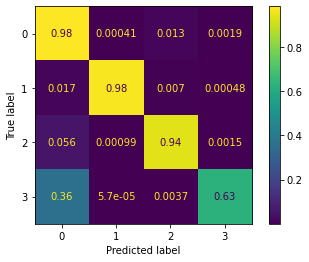

In [43]:
sklearn.metrics.plot_confusion_matrix(clf,train_data,y_train,normalize="true")

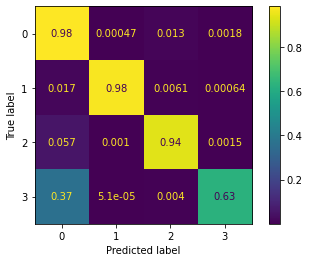

In [44]:
sklearn.metrics.plot_confusion_matrix(clf,cv_data,y_cv,normalize="true")

In [ ]:
y_train_result=np.argmax(y_train_hat,axis=1)
